# Preprocessing Molecules

You have a dataset of molecules (SMILES) and you want to preprocess it in order to clean and standardize the molecules. You can use `datamol` to easily design your own preprocessing pipeline and execute in parallel.

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import pandas as pd

import datamol as dm

The pipeline is applied on every molecules of the dataset and consist on the following steps:

- Convert to a mol.
- Fix common errors in the mol.
- Sanitize the mol.
- Standardize the mol.
- Generate a standardized SMILES.
- Generate SELFIES.
- Generate InChi and InChi key.

The resulting dataset can then saved as a CSV file or an SDF file (both files will have the exact same information stored).

In [2]:
# Load a dataset
data = dm.data.freesolv()
print(data.shape)
data.head()

(642, 4)


,iupac,smiles,expt,calc
0,"4-methoxy-N,N-dimethyl-benzamide",CN(C)C(=O)c1ccc(cc1)OC,-11.01,-9.625
1,methanesulfonyl chloride,CS(=O)(=O)Cl,-4.87,-6.219
2,3-methylbut-1-ene,CC(C)C=C,1.83,2.452
3,2-ethylpyrazine,CCc1cnccn1,-5.45,-5.809
4,heptan-1-ol,CCCCCCCO,-4.21,-2.917


### Preprocess using `pd.DataFrame.apply`

Easy and classic way to perform row-wise operations on a dataframe.

In [3]:
smiles_column = "smiles"

def _preprocess(row):
    mol = dm.to_mol(row[smiles_column], ordered=True)
    mol = dm.fix_mol(mol)
    mol = dm.sanitize_mol(mol, sanifix=True, charge_neutral=False)
    mol = dm.standardize_mol(mol, disconnect_metals=False, normalize=True, reionize=True, uncharge=False, stereo=True)

    row["standard_smiles"] = dm.standardize_smiles(dm.to_smiles(mol))
    row["selfies"] = dm.to_selfies(mol)
    row["inchi"] = dm.to_inchi(mol)
    row["inchikey"] = dm.to_inchikey(mol)
    return row

with dm.disable_rdkit_log():
    data_clean = data.apply(_preprocess, axis=1)
    
data_clean.head()

,iupac,smiles,expt,calc,standard_smiles,selfies,inchi,inchikey
0,"4-methoxy-N,N-dimethyl-benzamide",CN(C)C(=O)c1ccc(cc1)OC,-11.01,-9.625,COc1ccc(C(=O)N(C)C)cc1,[C][O][C][=C][C][=C][Branch1_1][Branch2_3][C][...,InChI=1S/C10H13NO2/c1-11(2)10(12)8-4-6-9(13-3)...,OCGXPFSUJVHRHA-UHFFFAOYSA-N
1,methanesulfonyl chloride,CS(=O)(=O)Cl,-4.87,-6.219,CS(=O)(=O)Cl,[C][S][Branch1_2][C][=O][Branch1_2][C][=O][Cl],"InChI=1S/CH3ClO2S/c1-5(2,3)4/h1H3",QARBMVPHQWIHKH-UHFFFAOYSA-N
2,3-methylbut-1-ene,CC(C)C=C,1.83,2.452,C=CC(C)C,[C][=C][C][Branch1_1][C][C][C],"InChI=1S/C5H10/c1-4-5(2)3/h4-5H,1H2,2-3H3",YHQXBTXEYZIYOV-UHFFFAOYSA-N
3,2-ethylpyrazine,CCc1cnccn1,-5.45,-5.809,CCc1cnccn1,[C][C][C][=C][N][=C][C][=N][Ring1][Branch1_2],"InChI=1S/C6H8N2/c1-2-6-5-7-3-4-8-6/h3-5H,2H2,1H3",KVFIJIWMDBAGDP-UHFFFAOYSA-N
4,heptan-1-ol,CCCCCCCO,-4.21,-2.917,CCCCCCCO,[C][C][C][C][C][C][C][O],"InChI=1S/C7H16O/c1-2-3-4-5-6-7-8/h8H,2-7H2,1H3",BBMCTIGTTCKYKF-UHFFFAOYSA-N


### Preprocess using `dm.parallelized`

Parallelize the preprocessing. This approach will only be faster if your dataset is very large.

In [4]:
smiles_column = "smiles"

def _preprocess(i, row):
    mol = dm.to_mol(row[smiles_column], ordered=True)
    mol = dm.fix_mol(mol)
    mol = dm.sanitize_mol(mol, sanifix=True, charge_neutral=False)
    mol = dm.standardize_mol(mol, disconnect_metals=False, normalize=True, reionize=True, uncharge=False, stereo=True)

    row["standard_smiles"] = dm.standardize_smiles(dm.to_smiles(mol))
    row["selfies"] = dm.to_selfies(mol)
    row["inchi"] = dm.to_inchi(mol)
    row["inchikey"] = dm.to_inchikey(mol)
    return row

with dm.disable_rdkit_log():
    data_clean = dm.parallelized(_preprocess, list(data.iterrows()), arg_type='args', progress=True)
    data_clean = pd.DataFrame(data_clean)
data_clean.head()

,iupac,smiles,expt,calc,standard_smiles,selfies,inchi,inchikey
0,"4-methoxy-N,N-dimethyl-benzamide",CN(C)C(=O)c1ccc(cc1)OC,-11.01,-9.625,COc1ccc(C(=O)N(C)C)cc1,[C][O][C][=C][C][=C][Branch1_1][Branch2_3][C][...,InChI=1S/C10H13NO2/c1-11(2)10(12)8-4-6-9(13-3)...,OCGXPFSUJVHRHA-UHFFFAOYSA-N
1,methanesulfonyl chloride,CS(=O)(=O)Cl,-4.87,-6.219,CS(=O)(=O)Cl,[C][S][Branch1_2][C][=O][Branch1_2][C][=O][Cl],"InChI=1S/CH3ClO2S/c1-5(2,3)4/h1H3",QARBMVPHQWIHKH-UHFFFAOYSA-N
2,3-methylbut-1-ene,CC(C)C=C,1.83,2.452,C=CC(C)C,[C][=C][C][Branch1_1][C][C][C],"InChI=1S/C5H10/c1-4-5(2)3/h4-5H,1H2,2-3H3",YHQXBTXEYZIYOV-UHFFFAOYSA-N
3,2-ethylpyrazine,CCc1cnccn1,-5.45,-5.809,CCc1cnccn1,[C][C][C][=C][N][=C][C][=N][Ring1][Branch1_2],"InChI=1S/C6H8N2/c1-2-6-5-7-3-4-8-6/h3-5H,2H2,1H3",KVFIJIWMDBAGDP-UHFFFAOYSA-N
4,heptan-1-ol,CCCCCCCO,-4.21,-2.917,CCCCCCCO,[C][C][C][C][C][C][C][O],"InChI=1S/C7H16O/c1-2-3-4-5-6-7-8/h8H,2-7H2,1H3",BBMCTIGTTCKYKF-UHFFFAOYSA-N


### Visualize

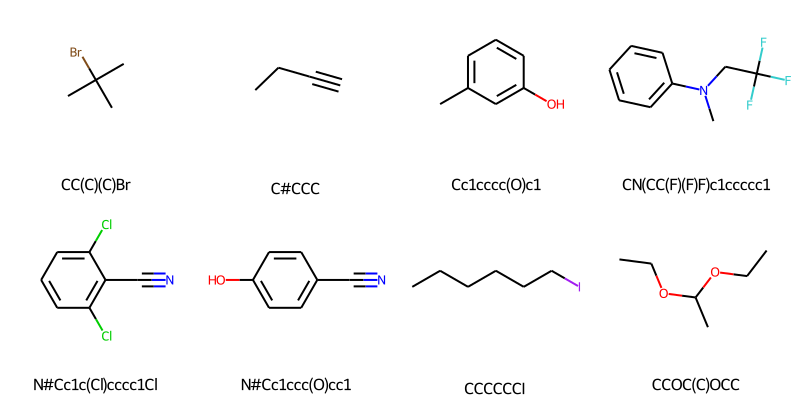

In [15]:
smiles = data_clean.sample(n=8, random_state=19)["standard_smiles"].tolist()
mols = [dm.to_mol(s) for s in smiles]
dm.viz.to_image(mols, legends=smiles, mol_size=(200, 200))

### Serialize the cleaned dataset

In [ ]:
# Save as CSV
# data_clean.to_csv("/my/path")

# Or save as an SDF
# dm.to_sdf(data_clean, "/my/path", smiles_column="standard_smiles")